# Preprocessing of Calcium signals

In [1]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('..')
from physion.analysis.read_NWB import Data

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Loading a datafile with Calcium Imaging data

In [2]:
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'data.nwb')
from physion.dataviz.show_data import MultimodalData
data = MultimodalData(filename)
data.plot([250.3, 351], 
              settings={'Photodiode':dict(fig_fraction=.1, subsampling=10, color='grey'),
                        'Locomotion':dict(fig_fraction=1, subsampling=10, color='b'),
                        'CaImaging':dict(fig_fraction=4, 
                                         quantity='CaImaging', subquantity='Fluorescence', color='green',
                                                   roiIndices=[2, 6, 9, 10, 13, 15, 16, 17, 38, 41]),
                        'VisualStim':dict(fig_fraction=0, size=0.04, color='black')},                    
              Tbar=2)

ModuleNotFoundError: No module named 'Ca_imaging.tools'

## Looking at ROI fluorescence and neuropil signals

## Deconvolution

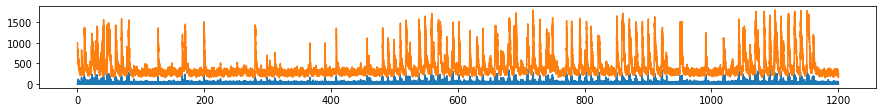

In [9]:
#import sys
#sys.path.append('/home/yann/suite2p')
from suite2p.extraction.dcnv import oasis
Dcnv = oasis(data.Fluorescence.data[:], 1000, 30., 1.)
ROI =1
fig, ax = plt.subplots(figsize=(15,1.5))
plt.plot(data.Fluorescence.timestamps[:], Dcnv[ROI,:], label='ROI')
plt.plot(data.Fluorescence.timestamps[:], data.Fluorescence.data[ROI,:], label='ROI')

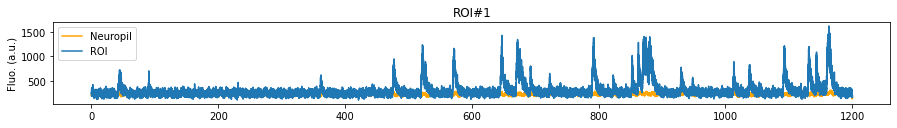

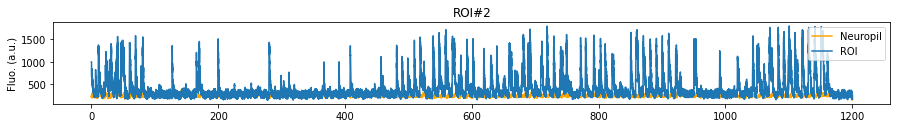

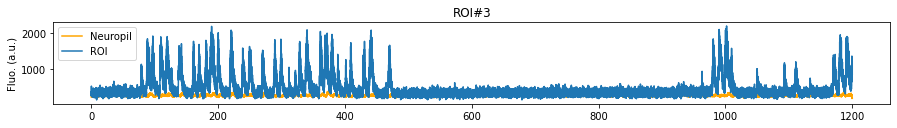

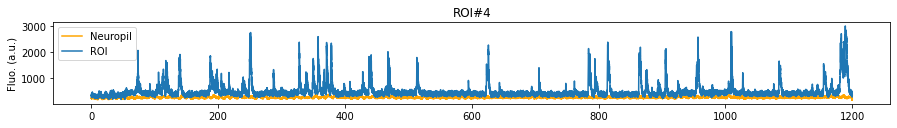

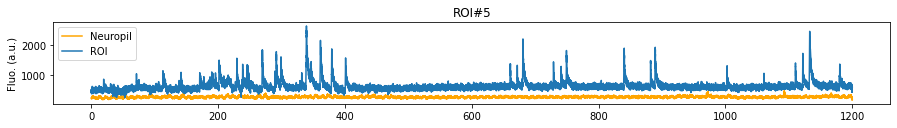

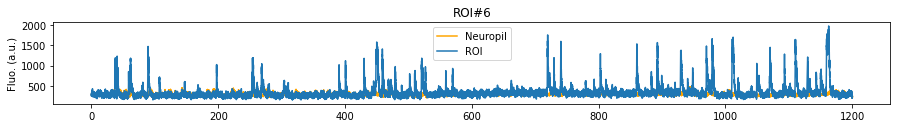

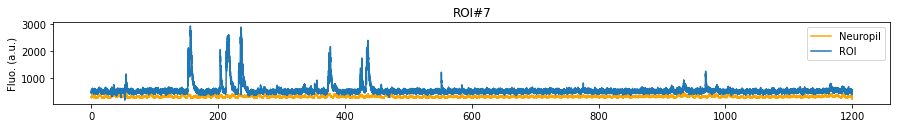

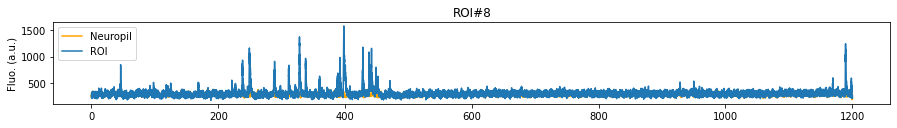

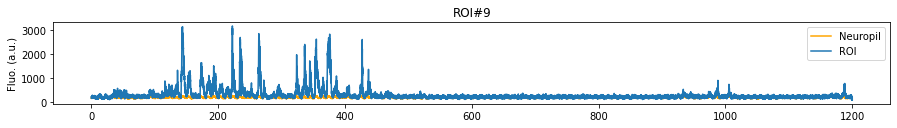

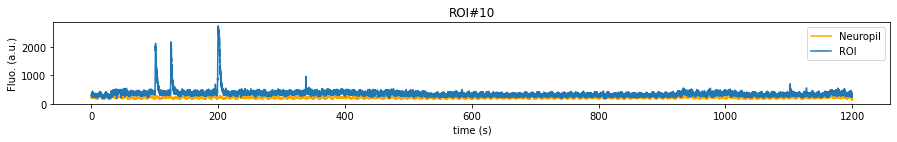

In [36]:
data = Data(filename)

for ROI in range(10):
    fig, ax = plt.subplots(figsize=(15,1.5))
    plt.plot(data.Fluorescence.timestamps[:], data.Neuropil.data[ROI,:], label='Neuropil', color='orange')
    plt.plot(data.Fluorescence.timestamps[:], data.Fluorescence.data[ROI,:], label='ROI')
    plt.title('ROI#%i' % (ROI+1))
    plt.legend()
    plt.ylabel('Fluo. (a.u.)')
plt.xlabel('time (s)');

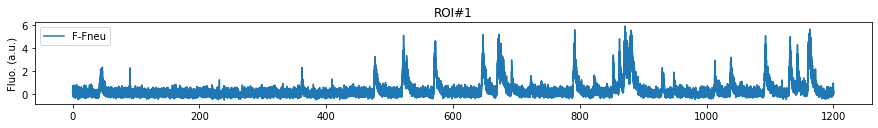

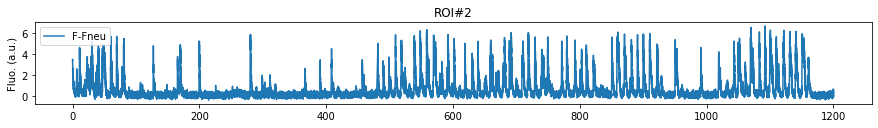

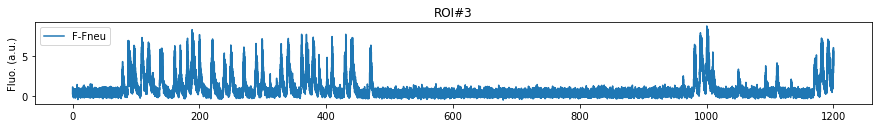

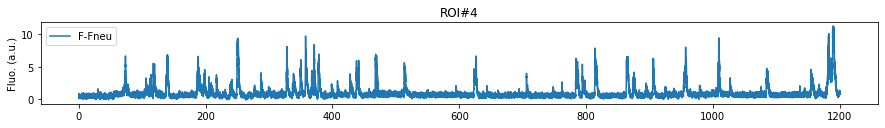

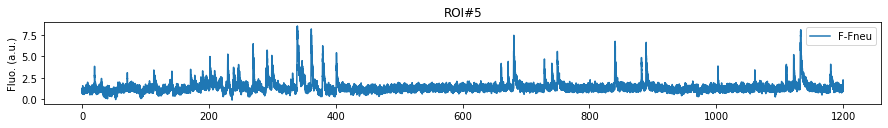

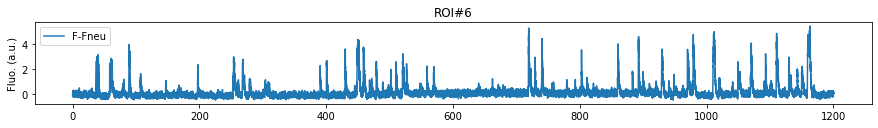

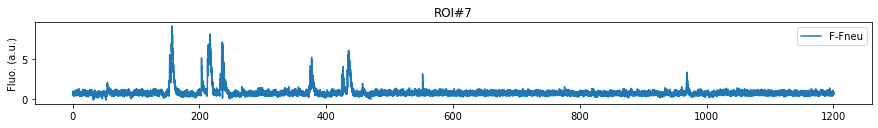

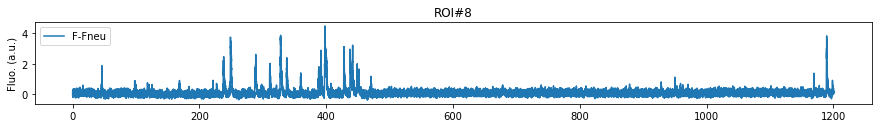

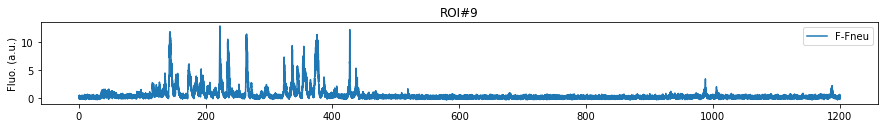

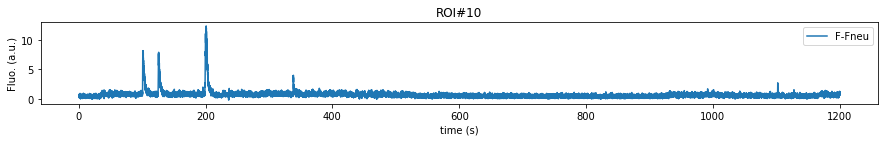

In [37]:
data = Data(filename)

for ROI in range(10):
    fig, ax = plt.subplots(figsize=(15,1.5))
    dF = (data.Fluorescence.data[ROI,:]-data.Neuropil.data[ROI,:])/data.Neuropil.data[ROI,:]
    plt.plot(data.Fluorescence.timestamps[:], dF, label='F-Fneu')
    plt.title('ROI#%i' % (ROI+1))
    plt.legend()
    plt.ylabel('Fluo. (a.u.)')
plt.xlabel('time (s)');

## Preprocessing parameters

In [144]:
preprocessing_params = {
    # fraction to be multiplied to neurpil for substraction from contaminated fluorescence
    'fraction_of_substracted_neuropil':0.7, # unitless
    # threshold to be applied 
    'percentile_threshold_for_baseline': 20, # unitless
    # window length for calculating delta F over F
    'sliding_window_for_baseline' : 10, # seconds
    # factor that the Ca-trace of a cell should exceed wrt to neuropil signal to be classified as a cell
    'fluo_factor_wrt_neuropil_for_inclusion':1.5, # unitless
}

In [153]:
from scipy.ndimage.filters import gaussian_filter1d # for gaussian smoothing

# numpy code for ~efficiently evaluating the distrib percentile over a sliding window
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))


def sliding_percentile(array, percentile, Window):

    x = np.zeros(len(array))
    y0 = strided_app(array, Window, 1)

    y = np.percentile(y0, percentile, axis=-1)
    
    x[:int(Window/2)] = y[0]
    x[-int(Window/2):] = y[-1]
    x[int(Window/2)-1:-int(Window/2)] = y
    
    return x


def from_raw_data_to_deltaFoverF(folder,
                                 freq_acq=30.,
                                 fraction_of_substracted_neuropil=0.7,
                                 percentile_threshold_for_baseline=0.2,
                                 sliding_window_for_baseline = 30.,
                                 fluo_factor_wrt_neuropil_for_inclusion = 1.5,
                                 verbose=False):

    if verbose:
        data = load_data_from_folder(folder)
        print(' data from: "%s" succesfully loaded ' % folder)

    print('----> Pre-processing the fluorescence of n=%i ROIs across n=%i time samples' % data['F'].shape)
    
    if verbose:
        print(' 1) [...] applying the ROI selection and the neuropil criteria')
    data['neuropil_cond'] = (np.mean(data['F'], axis=1)>fluo_factor_wrt_neuropil_for_inclusion*np.mean(data['Fneu'], axis=1))
    data['iscell'] = np.array(data['iscell'][:,0], dtype=bool)
    iscell = data['iscell'] & data['neuropil_cond']
    data['fluo_valid_cells'] = data['F'][iscell,:]
    print('----> n=%i ROIs are considered as valid cells' % np.sum(iscell))
    print
    
    if verbose:
        print(' 2) [...] substracting neuropil contamination')
    data['fluo_valid_cells'] -= fraction_of_substracted_neuropil*data['Fneu'][iscell,:]

    
    if verbose:
        print(' 3) [...] calculating sliding baseline per cell')
    Twidth = int(sliding_window_for_baseline*freq_acq) # window in sample units 
    # sliding minimum using the max filter of scipy, followed by gaussian smoothing
    data['sliding_min'] = 0*data['fluo_valid_cells']
    Twidth = int(sliding_window_for_baseline*freq_acq)
    for icell in range(data['fluo_valid_cells'].shape[0]):
        data['sliding_min'][icell,:] = gaussian_filter1d(\
                   sliding_percentile(data['fluo_valid_cells'][icell,:],
                                      percentile_threshold_for_baseline,
                                      Twidth), Twidth)
        
    if verbose:
        print(' 4) [...] performing DeltaF/F normalization')
    data['dFoF'] = np.divide((data['fluo_valid_cells']-data['sliding_min']),data['sliding_min'])

    # some useful quantites
    data['t'] = np.arange(int(data['fluo_valid_cells'].shape[1]))/freq_acq # time axis

    # formatted data
    Data = {}
    data['mean_Data'], data['std_Data'], data['norm_Data'] = {}, {}, {}
    
    for i in range(data['fluo_valid_cells'].shape[0]):
        key = 'cell%i' % (i+1)
        Data[key] = data['dFoF'][i, :]
        data['mean_Data'][key] = Data[key].mean()
        data['std_Data'][key] = Data[key].std()
        data['norm_Data'][key] = (Data[key]-Data[key].mean())/Data[key].std()
    if verbose:
        print('----> Pre-processing done !')

    return data, Data
